<a href="https://colab.research.google.com/github/BiancaRAF/transfer-learning-cat-dog/blob/main/transfer_learning_cat%26dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
%matplotlib inline

import os
import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
#https://github.com/thiagonebuloni/dio-unimed-data_science/blob/main/Machine%20Learning/projeto_final/transfer_learning.ipynb
#https://github.com/DanielKondo/dio-transfer-learning/blob/main/transfer_learning.ipynb


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/kagglecatsanddogs_5340.zip -d /dados/

In [26]:
#Remover o arquivo Thumbs.bd
os.remove('/dados/PetImages/Cat/Thumbs.db')
os.remove('/dados/PetImages/Dog/Thumbs.db')

In [27]:
#Como há uma limitação no Colab é necessário limitar a quantidade

for i in range(200, 12500):
  os.remove(f'/dados/PetImages/Dog/{i}.jpg')
  os.remove(f'/dados/PetImages/Cat/{i}.jpg')

In [28]:
root = '/dados/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['/dados/PetImages/Dog', '/dados/PetImages/Cat']


In [35]:
def get_image(path):
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


In [37]:
#Carregar as imagens para a pasta raiz

data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# Contar o número de classes
num_classes = len(categories)

In [38]:
#Colocar os dados em ordem aleatória
random.shuffle(data)

In [39]:
#Criar base de dados para treinar / validar / testar - separando a base de dados em 70%, 15% e 15%, respectivamente
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [40]:
#Separar os dados por rótulo 
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]


In [41]:
#Normalizar dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#Converter rótulos em vetores de "one-hot"
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(60, 2)


In [42]:
#Resumo
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 400 images from 2 categories
train / validation / test split: 280, 60, 60
training data shape:  (280, 224, 224, 3)
training labels shape:  (280, 2)


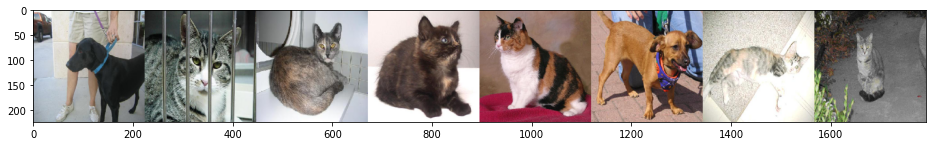

In [47]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [tf.keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image);

In [48]:
#Criando a rede neural
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [49]:
# Compilar o modelo para usar a função categórica de perda "cross-entropy" e o otimizador "adadelta"
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
3/3 [==============================] - 24s 6s/step - loss: 0.7205 - accuracy: 0.4893 - val_loss: 0.6819 - val_accuracy: 0.5667
Epoch 2/10
3/3 [==============================] - 20s 6s/step - loss: 0.7260 - accuracy: 0.5071 - val_loss: 0.7073 - val_accuracy: 0.4333
Epoch 3/10
3/3 [==============================] - 18s 5s/step - loss: 0.6929 - accuracy: 0.5143 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 21s 6s/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6886 - val_accuracy: 0.5667
Epoch 5/10
3/3 [==============================] - 18s 5s/step - loss: 0.6891 - accuracy: 0.5321 - val_loss: 0.6880 - val_accuracy: 0.5667
Epoch 6/10
3/3 [==============================] - 18s 5s/step - loss: 0.6885 - accuracy: 0.5107 - val_loss: 0.6878 - val_accuracy: 0.6500
Epoch 7/10
3/3 [==============================] - 25s 5s/step - loss: 0.6826 - accuracy: 0.5714 - val_loss: 0.6955 - val_accuracy: 0.4500
Epoch 8/10
3/3 [==================

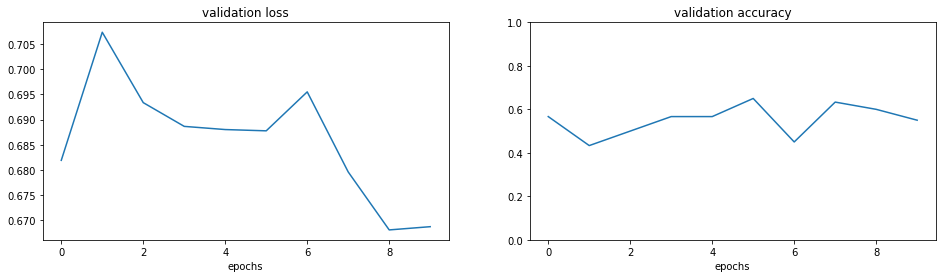

In [52]:
#Vamos plotar a perda de validação e a precisão de validação ao longo do processo 

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [53]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6609618067741394
Test accuracy: 0.699999988079071


In [54]:
#Transfer learning by starting with existing network

vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [55]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [56]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [57]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

Epoch 1/10
3/3 [==============================] - 191s 60s/step - loss: 1.1426 - accuracy: 0.5071 - val_loss: 0.7010 - val_accuracy: 0.4500
Epoch 2/10
3/3 [==============================] - 185s 58s/step - loss: 0.8188 - accuracy: 0.4643 - val_loss: 0.6586 - val_accuracy: 0.5667
Epoch 3/10
3/3 [==============================] - 185s 58s/step - loss: 0.6819 - accuracy: 0.5393 - val_loss: 0.8045 - val_accuracy: 0.4833
Epoch 4/10
3/3 [==============================] - 191s 59s/step - loss: 0.6802 - accuracy: 0.5750 - val_loss: 0.5360 - val_accuracy: 0.6500
Epoch 5/10
3/3 [==============================] - 183s 58s/step - loss: 0.5750 - accuracy: 0.6214 - val_loss: 0.4906 - val_accuracy: 0.8833
Epoch 6/10
3/3 [==============================] - 182s 57s/step - loss: 0.5132 - accuracy: 0.7929 - val_loss: 0.4820 - val_accuracy: 0.8000
Epoch 7/10
3/3 [==============================] - 190s 59s/step - loss: 0.4783 - accuracy: 0.8179 - val_loss: 0.4188 - val_accuracy: 0.9333
Epoch 8/10
3/3 [====

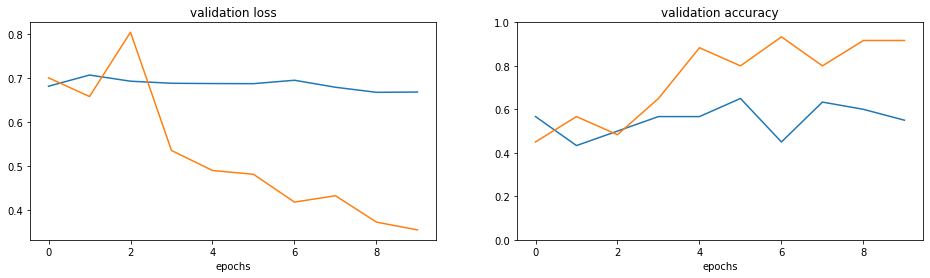

In [59]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [60]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.46411246061325073
Test accuracy: 0.7833333611488342
